In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch_geometric
from torch.utils.data import Subset, Dataset
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import networkx as nx
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import math
from einops import rearrange, repeat
from models_coarsen.gnet_coarsening import Sn_coarsen_layer, Sn_coarsen_layer_reflect, \
                        Sn_coarsen_net, flatten_ids, inv
from models_coarsen.gnet_coarsen_utils import get_clusters, get_cluster_idxs, \
                           get_masked_images, generate_grid_graph, \
                           prepare_data, run_exp, reflection_clusters
# reproducibility
np.random.seed(0)
torch.cuda.is_available()

True

In [9]:
#Load MNIST
MNIST_flag = False #True #False - FashionMNIST
subset_flag = True
N = 28

input_size  = N*N  # images are 28x28 pixels
output_size = 10      # there are 10 classes

 #FashionMNIST, with random horizontal flip!
transformations = transforms.Compose([
                    transforms.Resize((N, N)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                ])      
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True,transform=transformations)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transformations)



##TO-DO: subset
train_idx, validation_idx = train_test_split(np.arange(len(trainset)),
                                             train_size=100,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=trainset.targets)
# Subset dataset for train and val
train_subset = Subset(trainset, train_idx)
validation_dataset = Subset(trainset, validation_idx) #NOT-USE


if subset_flag:
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
else:
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)

test_idx, test_rest_idx = train_test_split(np.arange(len(testset)),
                                             test_size=0.9,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=testset.targets)  
test_subset = Subset(testset, test_idx)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)
print(f"training_size={len(train_subset)}, test_size={len(test_subset)}")


training_size=100, test_size=1000


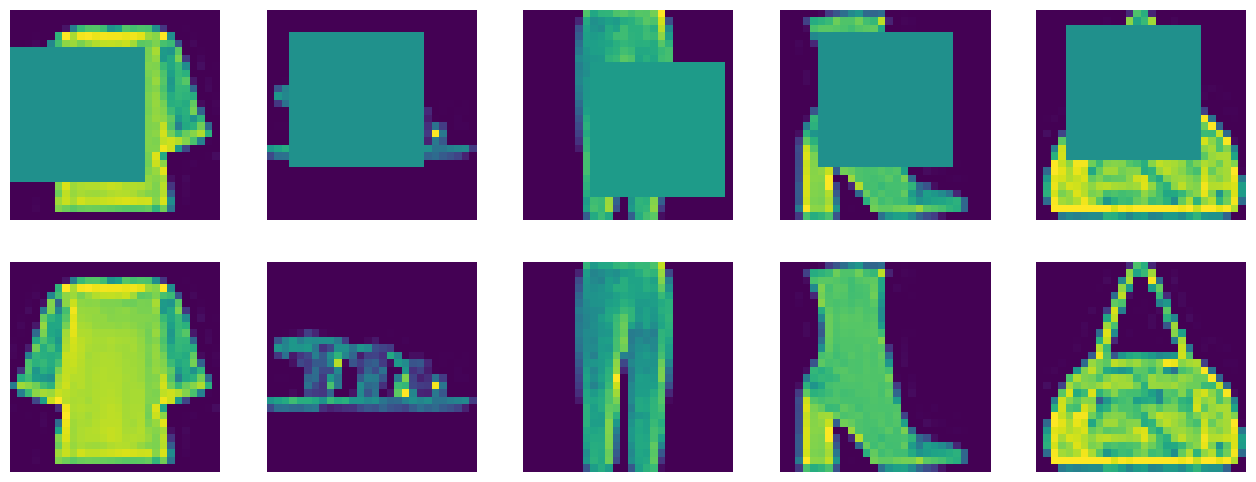

In [ ]:
train_y, _ = next(iter(train_loader))
train_x = get_masked_images(train_y, mask_size=14 if MNIST_flag else 18)
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    #x, y = train_loader.dataset.__getitem__(i)
    #x, y = next(iter(train_loader))
    #x, label = train_loader.dataset.__getitem__(i)
    x = train_x[i] #gauss_noise_tensor(rotate_img(x))
    if MNIST_flag:
        plt.imshow(x.squeeze().numpy())
    else:
        plt.imshow(x.permute(1,2,0).numpy())
    plt.axis('off')

for j in range(5):
    plt.subplot(2, 5, j + 6)
    #y, label = train_loader.dataset.__getitem__(j)
    y = train_y[j]#add_gauss_noise(adjust_contrast(x))
    #y = add_gauss_noise(gamma_correct(x))
    if MNIST_flag:
        plt.imshow(y.squeeze().numpy())
    else:
        plt.imshow(y.permute(1,2,0).numpy())

    plt.axis('off')    

In [ ]:

#initialize new model instances
gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
in_features = 1
out_features = 1
    
cluster_sizes = [1,2,4,7,14,28]
#save
total_runs = 3 #1
hid_dim = 28
print(f"running fashion!")
lr = 0.01
mask_size = 20 #"gamma" #"rotate" #"contrast"
n_epochs = 500

for run in range(total_runs):
#for run in range(total_runs-2, total_runs):
    results_val = dict()
    results_test = dict()
    results_val_rf = dict()
    results_test_rf = dict()

    print(f"running run={run}...")
    train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(train_loader, test_loader, device, mask_size)


    for size in cluster_sizes:
        print(f"Coarsen Sn: {size} x {size} clusters")
        torch.manual_seed(run)
        cluster_ids = get_cluster_idxs(N,size)
        #model_coarsen_Sn = Sn_coarsen_layer_reflect(cluster_ids, in_features, out_features)
        model_coarsen_Sn = Sn_coarsen_net(cluster_ids, in_features, out_features, hid_dim, reflect=False)
        model_coarsen_Sn.to(device)
        #train_loss, test_loss
        best_val, best_test, model_coarsen_Sn = run_exp(model_coarsen_Sn, train_x, train_y, val_x, val_y, \
                                                            test_x, test_y, device, \
                                                            n_epochs=n_epochs, run=run, lr=lr, mask_size=mask_size)  
        name = f"Sn_coarsen{size}"
        results_val[name] = best_val.item()
        results_test[name] = best_test.item()
        if size in [2, 14, 28]: #experiments with global reflection symmetry
            model_coarsen_Sn = Sn_coarsen_net(cluster_ids, in_features, out_features, hid_dim, reflect=True)
            model_coarsen_Sn.to(device)
            best_val, best_test, model_coarsen_Sn = run_exp(model_coarsen_Sn, train_x, train_y, val_x, val_y, \
                                                            test_x, test_y, device, \
                                                            n_epochs=n_epochs, run=run, lr=lr, mask_size=mask_size) 
            results_val_rf[name] = best_val.item()
            results_test_rf[name] = best_test.item()
    
    
    save_path = f"inpainting_results/reflect_paired/fashion_{mask_size}_run={run}"
    
    pickle.dump(results_test, open(f"{save_path}_rf=False_test.pkl", "wb"))
    pickle.dump(results_val, open(f"{save_path}_rf=False_val.pkl", "wb"))
    pickle.dump(results_test_rf, open(f"{save_path}_rf=True_test.pkl", "wb"))
    pickle.dump(results_val_rf, open(f"{save_path}_rf=True_val.pkl", "wb"))


In [17]:
def show_results(results_val, results_test):

    D_mean = {'name':[], 'val': [], 'test':[]}
    D_std = {'name':[], 'val': [], 'test':[]}
    for key in results_test[0].keys():
        D_mean['name'].append(key)
        D_std['name'].append(key)

        val_all = np.array([results_val[run][key] for run in range(total_runs)])
        mean = val_all.mean(axis=0) * 100
        D_mean['val'].append(mean)
        std = val_all.std(axis=0) * 100
        D_std['val'].append(std)

        val_all = np.array([results_test[run][key] for run in range(total_runs)])
        mean = val_all.mean(axis=0) * 100
        D_mean['test'].append(mean)
        std = val_all.std(axis=0) * 100
        D_std['test'].append(std)
        #print(f"Test MSE, {key}: mean={100*mean:.2f}, std={100*std:.2f}")

    df_mean = pd.DataFrame(data=D_mean).set_index("name").T
    df_std = pd.DataFrame(data=D_std).set_index("name").T

    return df_mean, df_std

In [20]:
total_runs = 3
reflect_val = [pickle.load(open(f"inpainting_results/reflect_paired/fashion_20_run={run}_rf=True_val.pkl", "rb")) for run in range(total_runs)]
reflect_test = [pickle.load(open(f"inpainting_results/reflect_paired/fashion_20_run={run}_rf=True_test.pkl", "rb")) for run in range(total_runs)]

fashion_results_val = [pickle.load(open(f"inpainting_results/reflect_paired/fashion_20_run={run}_rf=False_val.pkl", "rb")) for run in range(total_runs)]
fashion_results_test = [pickle.load(open(f"inpainting_results/reflect_paired/fashion_20_run={run}_rf=False_test.pkl", "rb")) for run in range(total_runs)]


In [21]:
reflect_mean, reflect_std = show_results(reflect_val, reflect_test)
fashion_df_mean, fashion_df_std = show_results(fashion_results_val, fashion_results_test)

In [23]:
fashion_df_mean

name,Sn_coarsen1,Sn_coarsen2,Sn_coarsen4,Sn_coarsen7,Sn_coarsen14,Sn_coarsen28
val,24.891104,23.086484,17.960369,16.835289,16.741346,16.951108
test,23.522210,22.834613,18.108837,16.282834,16.113668,16.117692


/tmp/ipykernel_2795519/921368137.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


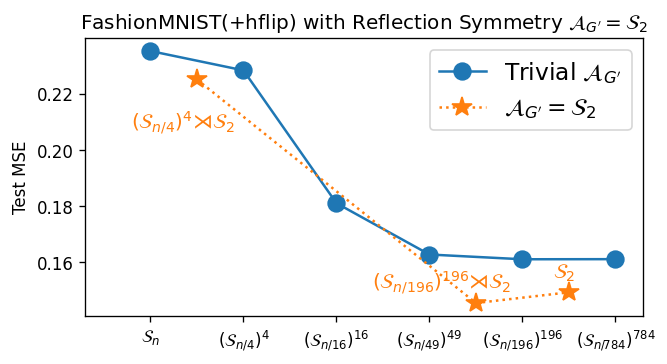

In [27]:
import matplotlib.ticker as mticker

plot_keys = [r"$S_n$(rf)",
            r"$\mathcal{S}_n$",
            r"$(\mathcal{S}_{{n/4}})^{4}$", 
            r"$(\mathcal{S}_{{n/16}})^{16}$",
            r"$(\mathcal{S}_{{n/49}})^{49}$", 
            r"$(\mathcal{S}_{{n/196}})^{196}$",   
             r"$(\mathcal{S}_{{n/784}})^{784}$"]
fig, ax = plt.subplots(figsize=(6,3),dpi=120)

ax.plot(np.arange(1,7),fashion_df_mean.iloc[1]*0.01, marker="o", markersize="10", 
                label=r"Trivial $\mathcal{A}_{G'}$")

extraticks = [1.5,4.5,5.5]

ax.plot(extraticks,reflect_mean.iloc[1]*0.01, marker="*", linestyle=":", markersize="12", \
          label=r"$\mathcal{A}_{G'} = \mathcal{S}_2$")

ax.set_title(r"FashionMNIST(+hflip) with Reflection Symmetry $\mathcal{A}_{G'} = \mathcal{S}_2$")
#ax.set_xticks(list(ax.get_xticks())[1:-1] + extraticks)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = plot_keys
ax.set_xticklabels(labels)
fig.text(0.26, 0.63, r"$(\mathcal{S}_{{n/4}})^{4}  \rtimes \mathcal{S}_2$" , fontsize=12, ha='center', c="tab:orange")
fig.text(0.62, 0.185, r"$(\mathcal{S}_{{n/196}})^{196} \rtimes \mathcal{S}_2$", fontsize=12, ha='center', c="tab:orange")
fig.text(0.79, 0.215,  r"$\mathcal{S}_2$", fontsize=12, ha='center', c="tab:orange")
ax.set_ylabel("Test MSE")

ax.set_xlim(0.3,6.3)
ax.legend(fontsize=14)
plt.show()